# 9.7单发多框检测（SSD）

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import time
import numpy as np

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1、流程细节

### 1、类别预测层

设目标的类别个数为 q 。每个锚框的类别个数将是 q+1 ，其中类别0表示锚框只包含背景。

在某个尺度下，设特征图的高和宽分别为 h 和 w ，如果以其中每个单元为中心生成 a 个锚框，那么我们需要对 hwa 个锚框进行分类。

如果使用全连接层作为输出，很容易导致模型参数过多。回忆“网络中的网络（NiN）”一节介绍的使用卷积层的通道来输出类别预测的方法。单发多框检测采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高和宽的卷积层。这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。考虑输出和输入同一空间坐标 (x,y) ：输出特征图上 (x,y) 坐标的通道里包含了以输入特征图 (x,y) 坐标为中心生成的所有锚框的类别预测。因此输出通道数为 a(q+1) ，其中索引为 i(q+1)+j （ 0≤j≤q ）的通道代表了索引为 i 的锚框有关类别索引为 j 的预测。

In [2]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return torch.nn.Conv2d(num_inputs, num_anchors*(num_classes+1), kernel_size=3, padding=1)

### 2、边界框预测层
边界框预测层的设计与类别预测层的设计类似。唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是 q+1 个类别。

In [3]:
def bbox_predictor(num_inputs, num_anchors):
    return torch.nn.Conv2d(num_inputs, num_anchors*4, kernel_size=3, padding=1)

### 3、连结多尺度的预测

前面提到，单发多框检测根据多个尺度下的特征图生成锚框并预测类别和偏移量。由于每个尺度上特征图的形状或以同一单元为中心生成的锚框个数都可能不同，因此不同尺度的预测输出形状可能不同。

在下面的例子中，我们对同一批量数据构造两个不同尺度下的特征图Y1和Y2，其中Y2相对于Y1来说高和宽分别减半。以类别预测为例，假设以Y1和Y2特征图中每个单元生成的锚框个数分别是5和3，当目标类别个数为10时，类别预测输出的通道数分别为 5×(10+1)=55 和 3×(10+1)=33 。预测输出的格式为(批量大小, 通道数, 高, 宽)。可以看到，除了批量大小外，其他维度大小均不一样。我们需要将它们变形成统一的格式并将多尺度的预测连结，从而让后续计算更简单。

In [4]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
(Y1.shape, Y2.shape)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的(批量大小, 高 × 宽 × 通道数)的格式，以方便之后在维度1上的连结。

In [5]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [6]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### 4、高宽减半块
为了在多尺度检测目标，下面定义高和宽减半块down_sample_blk。它串联了两个填充为1的 3×3 卷积层和步幅为2的 2×2 最大池化层。我们知道，填充为1的 3×3 卷积层不改变特征图的形状，而后面的池化层则直接将特征图的高和宽减半。由于 1×2+(3−1)+(3−1)=6 ，输出特征图中每个单元在输入特征图上的感受野形状为 6×6 。可以看出，高和宽减半块使输出特征图中每个单元的感受野变得更广阔。

In [7]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(torch.nn.BatchNorm2d(out_channels))
        blk.append(torch.nn.ReLU())
        in_channels = out_channels
    blk.append(torch.nn.MaxPool2d(2))
    return torch.nn.Sequential(*blk)

In [8]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### 5、基础网络块
基础网络块用来从原始图像中抽取特征。为了计算简洁，我们在这里构造一个小的基础网络。该网络串联3个高和宽减半块，并逐步将通道数翻倍。当输入的原始图像的形状为 256×256 时，基础网络块输出的特征图的形状为 32×32 。

In [9]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters)-1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return torch.nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### 6、完整的模型
单发多框检测模型一共包含5个模块，每个模块输出的特征图既用来生成锚框，又用来预测这些锚框的类别和偏移量。
- 第一模块为基础网络块
- 第二模块至第四模块为高和宽减半块
- 第五模块使用全局最大池化层将高和宽降到1。

因此第二模块至第五模块均为图9.4中的多尺度特征块。

In [10]:
def get_blk(i):
    if i==0:
        blk = base_net()
    elif i==1:
        blk = down_sample_blk(64, 128)
    elif i==4:
        blk = torch.nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

接下来，我们定义每个模块如何进行前向计算。

与之前介绍的卷积神经网络不同，这里不仅返回卷积计算输出的特征图Y，还返回根据Y生成的当前尺度的锚框，以及基于Y预测的锚框类别和偏移量。

In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

我们提到，图9.4中较靠近顶部的多尺度特征块用来检测尺寸较大的目标，因此需要生成较大的锚框。我们在这里先将0.2到1.05之间均分5份，以确定不同尺度下锚框大小的较小值0.2、0.37、0.54等，再按 √0.2×0.37=0.272 、√0.37×0.54=0.447 等来确定不同尺度下锚框大小的较大值。

In [12]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
# 这里的计算参见8.4.1
num_anchors = len(sizes[0])+len(ratios[0])-1

定义出完整的模型TinySSD

In [13]:
class TinySSD(torch.nn.Module):
    
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # The assignment statement is self.blk_i = get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))
            
    def forward(self, X):
        
        anchors, cls_preds, bbox_preds = [None]*5, [None]*5, [None]*5
        
        for i in range(5):
            # getattr(self, 'blk_%d' % i) accesses self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], 
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}')
            )
            
        # In the reshape function, 0 indicates that the batch size remains
        # unchanged
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        
        # batch_size, num_anchors, num_classes
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes+1
        )
        bbox_preds = concat_preds(bbox_preds)
        
        return anchors, cls_preds, bbox_preds

我们创建单发多框检测模型实例并对一个高和宽均为256像素的小批量图像X做前向计算。我们在之前验证过，第一模块输出的特征图的形状为 32×32 。由于第二至第四模块为高和宽减半块、第五模块为全局池化层，并且以特征图每个单元为中心生成4个锚框，每个图像在5个尺度下生成的锚框总数为 (32^2+16^2+8^2+4^2+1)×4=5444 。

In [14]:
net = TinySSD(num_classes=1)

X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## 2、训练模型

我们读取“目标检测数据集（皮卡丘）”一节构造的皮卡丘数据集。

In [15]:
batch_size = 32
train_iter, _ = d2l.load_data_pikachu(batch_size)

在皮卡丘数据集中，目标的类别数为1。定义好模型以后，我们需要初始化模型参数并定义优化算法。

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = TinySSD(num_classes=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### 2、定义损失函数和评价函数

目标检测有两个损失：
- 一是有关锚框类别的损失，我们可以重用之前图像分类问题里一直使用的交叉熵损失函数；
- 二是有关正类锚框偏移量的损失。预测偏移量是一个回归问题，但这里不使用前面介绍过的平方损失，而使用 L1 范数损失，即预测值与真实值之间差的绝对值。

掩码变量bbox_masks令负类锚框和填充锚框不参与损失的计算。最后，我们将有关锚框类别和偏移量的损失相加得到模型的最终损失函数。

In [17]:
cls_loss = torch.nn.CrossEntropyLoss(reduction='none')
bbox_loss = torch.nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), 
                  cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds*bbox_masks, 
                    bbox_labels*bbox_masks).mean(dim=1)
    return cls+bbox

我们可以沿用准确率评价分类结果。因为使用了 L1 范数损失，我们用平均绝对误差评价边界框的预测结果。

In [18]:
def cls_eval(cls_preds, cls_labels):
    # Because the category prediction results are placed in the final
    # dimension, argmax must specify this dimension
    return float(
        (cls_preds.argmax(dim=-1).type(
            cls_labels.dtype
        )==cls_labels).sum()
    )

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels-bbox_preds)*bbox_masks)).sum())

### 3、训练
在训练模型时，我们需要在模型的前向计算过程中生成多尺度的锚框anchors，并为每个锚框预测类别cls_preds和偏移量bbox_preds。之后，我们根据标签信息Y为生成的每个锚框标注类别cls_labels和偏移量bbox_labels。最后，我们根据类别和偏移量的预测和标注值计算损失函数。为了代码简洁，这里没有评价测试数据集。

In [19]:
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # PyTorch auto-broadcasts singleton dimensions
    # 左上角取最大
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    # 右下角取最小
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # Find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

In [20]:
def match_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    # 为与真实边框最相似的锚框分配label
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 对于第i个锚框与第j个真实边框，我们用矩阵第i行，第j列的元素表示其二者的IoU
    jaccard = compute_jaccard(anchors, ground_truth)
    # 初始化一个张量用于存储每一个锚框对应的真实边框
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    # 根据阈值为锚框分配真实边框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious>=0.5).reshape(-1)
    box_j = indices[max_ious>=0.5]
    anchors_bbox_map[anc_i] = box_j
    # 为每一个锚框匹配最大的iou对应的真实边框
    anc_i = torch.argmax(jaccard, dim=0)
    box_j = torch.arange(num_gt_boxes, device=device)
    anchors_bbox_map[anc_i] = box_j
    return anchors_bbox_map

def box_corner_to_center(boxes):
    # 将(左上角坐标, 右下角坐标)转换为(中心点坐标, 宽, 长)
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = np.stack((cx, cy, w, h), axis=1)
    return boxes

def offset_boxes(anchors, assigned_bb, eps=1e-6):
    # 为锚框标注偏移量
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * np.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = np.concatenate([offset_xy, offset_wh], axis=1)
    return offset

In [21]:
def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # 取当前边框的标签
        label = labels[i, :, :]
        # 第一列为标签
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors, device)
        # 只保留匹配上的，未匹配的为-1被过滤了
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 初始化锚框标签
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        # 初始化偏移量
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # 为锚框标记类别
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        # 加1为了使原来的背景变为标签0
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 计算偏移量,没有匹配上就是4个0
        offset = torch.from_numpy(offset_boxes(anchors, assigned_bb)) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [22]:
num_epochs = 30
net = net.to(device)

for epoch in range(num_epochs):
    acc_sum,  mae_sum= 0, 0
    num_examples, num_labels = 0, 0
    net.train()
    begin = time.time()
    for data in train_iter:
        
        features, target = data['image'], data['label']
        X, Y = features.to(device), target.to(device)
         
        optimizer.zero_grad()
        
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        
         # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y.cpu())
        bbox_labels, bbox_masks, cls_labels = bbox_labels.to(device), bbox_masks.to(device), cls_labels.to(device)
        
         # 为每个锚框标注类别和偏移量
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        
        optimizer.step()
        
        acc_sum += cls_eval(cls_preds, cls_labels)
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        num_examples += bbox_labels.numel()
        num_labels += cls_labels.numel()
        
    cls_err, bbox_mae = 1-acc_sum/num_labels, mae_sum/num_examples
    if (epoch+1) % 5==0:
        print(f'epoch {epoch+1}, class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}, time {time.time()-begin:.1f} sec')

epoch 5, class err 3.90e-04, bbox mae 5.05e-04, time 4.3 sec
epoch 10, class err 3.90e-04, bbox mae 4.59e-04, time 4.4 sec
epoch 15, class err 3.90e-04, bbox mae 3.86e-04, time 4.4 sec
epoch 20, class err 3.89e-04, bbox mae 3.01e-04, time 4.4 sec
epoch 25, class err 3.84e-04, bbox mae 2.71e-04, time 4.4 sec
epoch 30, class err 3.79e-04, bbox mae 2.57e-04, time 4.4 sec


## 3、预测目标

In [39]:
def nms(boxes, scores, iou_threshold):
    boxes = torch.tensor(boxes)
    # 降序排列，并返回索引
    B = torch.argsort(scores, dim=-1, descending=True)
    # 保存保留框的索引
    keep = []
    while B.numel() > 0:
        # 最大值的索引
        i = B[0]
        keep.append(i)
        # 终止条件，1个框无法计算交并比
        if B.numel() == 1:
            break
        # 当前框与剩余框的交并比
        iou = compute_jaccard(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        # 筛选满足条件的框，返回其索引
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        # 加1是因为当前框已经计算过，所以整体索引加1才是剩余框的索引
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [40]:
# 将(中心点坐标, 宽, 长)转换为(左上角坐标, 右下角坐标)
def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = np.stack((x1, y1, x2, y2), axis=1)
    return boxes
# 根据锚框和偏移量反推预测的边框
def offset_inverse(anchors, offset_preds):
    c_anc = torch.from_numpy(box_corner_to_center(anchors))
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = np.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = np.concatenate([c_pred_bb_xy, c_pred_bb_wh], axis=1)
    predicted_bb = box_center_to_corner(c_pred_bb)
    return predicted_bb

In [41]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5, score_threshold=0.0099):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        # 每一列最大值极其索引，且过滤掉背景概率
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, 0.5)
        # 将所有未保留的框设为背景类
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        # 不重复元素（类别），不重复元素的个数（类别数）
        uniques, counts = combined.unique(return_counts=True)
        # 剔除掉只出现过1次的索引
        non_keep = uniques[counts==1]
        all_id_sorted = torch.cat((keep, non_keep))
        # 设为背景
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        predicted_bb = torch.tensor(predicted_bb, device=device)
        pred_info = torch.cat(
            (class_id.unsqueeze(1).float(), 
            conf[all_id_sorted].unsqueeze(1), 
            predicted_bb[all_id_sorted]), dim=1
        )
        out.append(pred_info)
    return torch.stack(out)

In [42]:
from copy import deepcopy
img = Image.open('../../data/pikachu.jpg')
img = np.array(img, dtype=np.float32) / 255.0
X = torch.from_numpy(img)
# [batch_size, 3, image_height, image_width]  ([B, C, H, W])
show_img = deepcopy(X*255.0)
X = X.permute(2, 0, 1).unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

show_img = show_img.permute(2, 0, 1).unsqueeze(0).float()
show_img = show_img.squeeze(0).permute(1, 2, 0).long()

In [43]:
img.shape

torch.Size([512, 512, 3])

In [44]:
import torch.nn.functional as F
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs.detach().cpu(), bbox_preds.detach().cpu(), anchors.detach().cpu())
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]
output = predict(X)

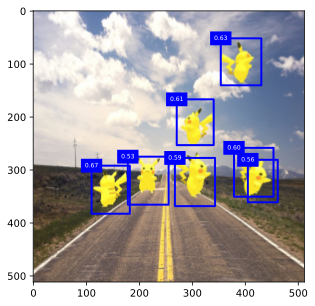

In [46]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device).float()]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score)
        d2l.plt.savefig('1.jpg')
display(show_img, output.cpu(), threshold=0.46)